# 00 - Nengo Test

This notebook follows the tutorial from Nengo Summer School - [Lecture 5](https://www.youtube.com/watch?v=UN3tKSuno1k). This implements a SNN to produce a motor velocity toward food location when fear <= 0 else toward 0,0. This is perhaps more complicated than what we will do in other notebooks.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/neuromorphs/grill-srnn-pfc/blob/master/notebooks/00_nengo_test.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/neuromorphs/grill-srnn-pfc/blob/master/notebooks/00_nengo_test.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [ ]:
#@title Environment Setup
try:
    # See if we are running on google.colab
    from google.colab import files
    IN_COLAB = True
    !pip install nengo git+https://github.com/neuromorphs/grill-srnn-pfc.git 
    # TODO: kaggle creds for downloading data 
    
except ModuleNotFoundError:
    IN_COLAB = False

%load_ext autoreload
%autoreload 2

The following model is nearly functionally identical to the model in the summer school video linked above. One tweak is that the fight-or-flight velocity in `home_func` is scaled to make it invariant to the distance from the origin.

The API used to build the model is quite different. Here we use the principles laid out in the Nengo documentation on [Designing networks](https://www.nengo.ai/nengo/examples/usage/network-design.html) to build a reusable model.

In [ ]:
import nengo
import numpy as np

class Critter(nengo.Network):
    def __init__(self, base_neurons=50, tau=0.1):
        # Inputs - need to be wired later by nengo.Node
        # Current representation of food location; x, y.
        self.food = nengo.Ensemble(n_neurons=2*base_neurons, dimensions=2,
                                   label='food')
        # Current representation of fear
        self.fear = nengo.Ensemble(n_neurons=base_neurons, dimensions=1, label='fear')
        
        # Combined representation of food and fear
        self.do_food = nengo.Ensemble(n_neurons=6*base_neurons, dimensions=3, label='do_food')
        nengo.Connection(self.fear, self.do_food[0])
        nengo.Connection(self.food, self.do_food[1:])
        
        # Representation of current motor commands
        self.motor = nengo.Ensemble(n_neurons=2*base_neurons, dimensions=2, label='motor')
        # food contribution to motor 0 if fear > 0 else food_xy
        nengo.Connection(self.do_food, self.motor,
                         function=lambda x: (0, 0) if x[0] > 0 else x[1:])
        
        # Representation of current position
        self.pos = nengo.Ensemble(n_neurons=10*base_neurons, dimensions=2, radius=1, label='pos')
        # Recurrent connection --> Integrator
        nengo.Connection(self.pos, self.pos, synapse=tau)
        # Position is updated based on current motor command
        nengo.Connection(self.motor, self.pos, synapse=tau, transform=0.1)
        
        # Representation of flight response - combination of fear and current location
        self.do_home = nengo.Ensemble(n_neurons=6*base_neurons, dimensions=3, label='do_home')
        nengo.Connection(self.fear, self.do_home[0])
        nengo.Connection(self.pos, self.do_home[1:])
        # If fear > 0, return home at constant velocity.
        def home_func(x, speed=2):
            fear, pos_x, pos_y = x
            if fear > 0:
                vel = -speed / (np.sqrt(pos_x**2 + pos_y**2) + 1e-10)
                return vel * pos_x, vel * pos_y
            else:
                return 0, 0
        nengo.Connection(self.do_home, self.motor, function=home_func)

## Interactive Model

Here we make the interactive form of the model.

Right click on the `stim_` nodes to add sliders, and right click on the 2-dimension ensembles and add x,y plots. Then run the model. While running, play with the sliders.

In [ ]:
#Nengo GUI visualizer for visualizing the network
from nengo_gui.ipython import IPythonViz

def critter_interactive(stim_food=[0, 0], stim_fear=-1):
    with nengo.Network() as net:
        net.critter = Critter()
        net.food_node = nengo.Node(output=stim_food, label='stim_food')
        nengo.Connection(net.food_node, net.critter.food)
        net.fear_node = nengo.Node(output=stim_fear, label='stim_fear')
        nengo.Connection(net.fear_node, net.critter.fear)
    return net

inet = critter_interactive()
IPythonViz(inet)

## Non-interactive Form

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

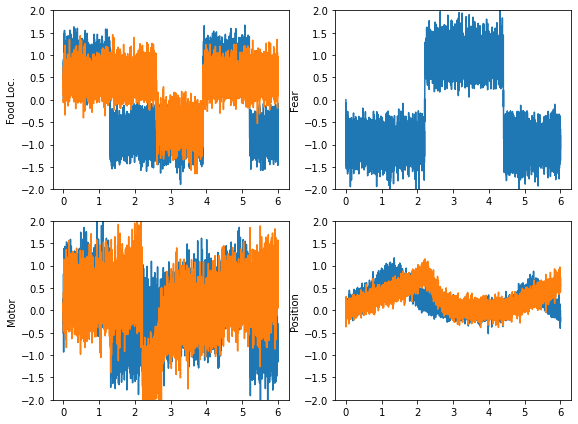

In [ ]:
from nengo.processes import Piecewise, PresentInput
import matplotlib.pyplot as plt


def test_critter(net, sim_time=6):
    with net:
        critter = Critter()
        food_process = PresentInput([[0.8, 0.5], [-0.8, 0.5], [-0.8, -0.6]],
                                    presentation_time=1.3)
        food_inp = nengo.Node(food_process)
        nengo.Connection(food_inp, critter.food)
        fear_process = PresentInput([[-1], [1.0]], presentation_time=2.2)
        # fear_process = Piecewise({0: -1, 0.7: 0.5, 1: -1, 1.7: 1.0, 2.6: -1.0})
        fear_inp = nengo.Node(fear_process)
        nengo.Connection(fear_inp, critter.fear)
        
        food_p = nengo.Probe(critter.food)
        fear_p = nengo.Probe(critter.fear)
        do_food_p = nengo.Probe(critter.do_food)
        motor_p = nengo.Probe(critter.motor)
        pos_p = nengo.Probe(critter.pos)
        do_home_p = nengo.Probe(critter.do_home)
    
    with nengo.Simulator(net) as sim:
        sim.run(sim_time)
    t = sim.trange()
    
    ylims = [-2.0, 2.0]
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 2, 1)
    plt.plot(t, sim.data[food_p])
    plt.ylim(ylims)
    plt.ylabel('Food Loc.')
    plt.subplot(2, 2, 2)
    plt.plot(t, sim.data[fear_p])
    plt.ylim(ylims)
    plt.ylabel('Fear')
    plt.subplot(2, 2, 3)
    plt.plot(t, sim.data[motor_p])
    plt.ylim(ylims)
    plt.ylabel('Motor')
    plt.subplot(2, 2, 4)
    plt.plot(t, sim.data[pos_p])
    plt.ylim(ylims)
    plt.ylabel('Position')
    plt.ylim(ylims)
    plt.tight_layout()
    
net = nengo.Network()
test_critter(net)